In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import sqlalchemy
import pandas as pd

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
query = """
SELECT 
offer_model.offer_id,
offer_model.origin, offer_model.dest, offer_model.carrier,
offer_model.base_offer_amount, offer_model.currency,
offer_model.locale, offer_model.departure_time,
offer_model.departure_time_server, offer_model.duration,
offer_model.fare_class, offer_model.flight_number,
offer_model.instant_upgrade, offer_model.is_recent_offer,
offer_model.offer_amount, offer_model.offer_amount_total,
offer_model.offer_expiration_cutoff_local, offer_model.offer_expiration_cutoff_server,
offer_model.offer_expiration_minutes, offer_model.offer_modification_cutoff_hours,
offer_model.offer_modification_cutoff_local, offer_model.offer_modification_cutoff_server,
offer_model.pax, offer_model.point_of_sale, offer_model.product_id,
offer_model.quantity, offer_model.refundable,
offer_model.slider_lower_limit, offer_model.slider_starting_amount, offer_model.slider_upper_limit,
offer_model.status, offer_model.submission_date, offer_model.upgrade_type,
offer_model.has_errors,
offer_amount / offer_currency.rate as offer_amount_usd,
offer_amount_total / offer_currency.rate as offer_amount_total_usd,
slider_lower_limit / offer_currency.rate as slider_min_usd,
slider_upper_limit / offer_currency.rate as slider_max_usd,
slider_starting_amount / offer_currency.rate as slider_starting_usd,
misc_fields.equip, misc_fields.distance
FROM
offer_model
INNER JOIN (
SELECT
currency_code,
MAX(event_time) as event_time,
MAX(rate) as rate
FROM
com_currency
WHERE
event_time = '2019-03-29 00:00:00'
GROUP BY
currency_code
) offer_currency ON offer_model.currency = offer_currency.currency_code
INNER JOIN (
SELECT 
variation.equip, oltp_flight_inventory.distance,
oltp_flight_inventory.id as offer_id
FROM oltp_flight_inventory_variation as variation
INNER JOIN oltp_flight_inventory 
ON variation.product_id = oltp_flight_inventory.id
GROUP BY offer_id, variation.equip, oltp_flight_inventory.distance
) misc_fields ON offer_model.offer_id = misc_fields.offer_id
WHERE offer_model.carrier = 'LH'
"""

df = sqlContext.read \
  .format("jdbc") \
  .option("url", "jdbc:redshift://prod-dw-east.c9bkicpvicdl.us-east-1.redshift.amazonaws.com:5439/plusgrade") \
  .option("user", "ke_yao") \
  .option("password", "9hidiLbhPz0j5BzEVSpo6tmN") \
  .option("query", query) \
  .load()

In [4]:
df.printSchema()

root
 |-- offer_id: long (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- base_offer_amount: decimal(12,2) (nullable = true)
 |-- currency: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- departure_time_server: timestamp (nullable = true)
 |-- duration: integer (nullable = true)
 |-- fare_class: string (nullable = true)
 |-- flight_number: integer (nullable = true)
 |-- instant_upgrade: boolean (nullable = true)
 |-- is_recent_offer: boolean (nullable = true)
 |-- offer_amount: decimal(12,2) (nullable = true)
 |-- offer_amount_total: decimal(12,2) (nullable = true)
 |-- offer_expiration_cutoff_local: timestamp (nullable = true)
 |-- offer_expiration_cutoff_server: timestamp (nullable = true)
 |-- offer_expiration_minutes: integer (nullable = true)
 |-- offer_modification_cutoff_hours: integer (nullable = true)
 |-- offer_modificatio

In [6]:
import numpy as np

df2 = df.select(["slider_min_usd", "slider_max_usd"]).toPandas()

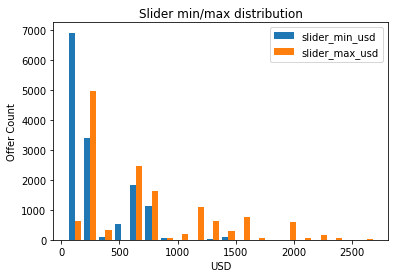

In [13]:
import matplotlib.pyplot as plt

plt.hist(df2, bins=20, label=['slider_min_usd', 'slider_max_usd'])
plt.xlabel('USD')
plt.ylabel('Offer Count')
plt.title('Slider min/max distribution')
plt.legend()
plt.savefig('Sliderminmaxdist.png', dpi=300)